<a href="https://colab.research.google.com/github/Kafi-Hersi/House-price-predictions-ML/blob/main/House_price_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Log in

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

house_prices_advanced_regression_techniques_path = kagglehub.competition_download('house-prices-advanced-regression-techniques')

print('Data source import complete.')


Data source import complete.


### Importing libraries

In [ ]:
%pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from xgboost import XGBRegressor

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

%matplotlib inline
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [ ]:
train_ds = pd.read_csv(f'{house_prices_advanced_regression_techniques_path}/train.csv')
test_ds = pd.read_csv(f'{house_prices_advanced_regression_techniques_path}/test.csv')

In [ ]:
print(train_ds.shape)
print(test_ds.shape)

(1460, 81)
(1459, 80)


In [ ]:
train_ds.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Basic EDA

In [ ]:
cols_na = {col: float(round(train_ds[col].isnull().mean(), 4)) for col in train_ds.columns if train_ds[col].isnull().sum() > 1}
sorted(cols_na.items(), key=lambda x: x[1], reverse=True)

[('PoolQC', 0.9952),
 ('MiscFeature', 0.963),
 ('Alley', 0.9377),
 ('Fence', 0.8075),
 ('MasVnrType', 0.5973),
 ('FireplaceQu', 0.4726),
 ('LotFrontage', 0.1774),
 ('GarageType', 0.0555),
 ('GarageYrBlt', 0.0555),
 ('GarageFinish', 0.0555),
 ('GarageQual', 0.0555),
 ('GarageCond', 0.0555),
 ('BsmtExposure', 0.026),
 ('BsmtFinType2', 0.026),
 ('BsmtQual', 0.0253),
 ('BsmtCond', 0.0253),
 ('BsmtFinType1', 0.0253),
 ('MasVnrArea', 0.0055)]

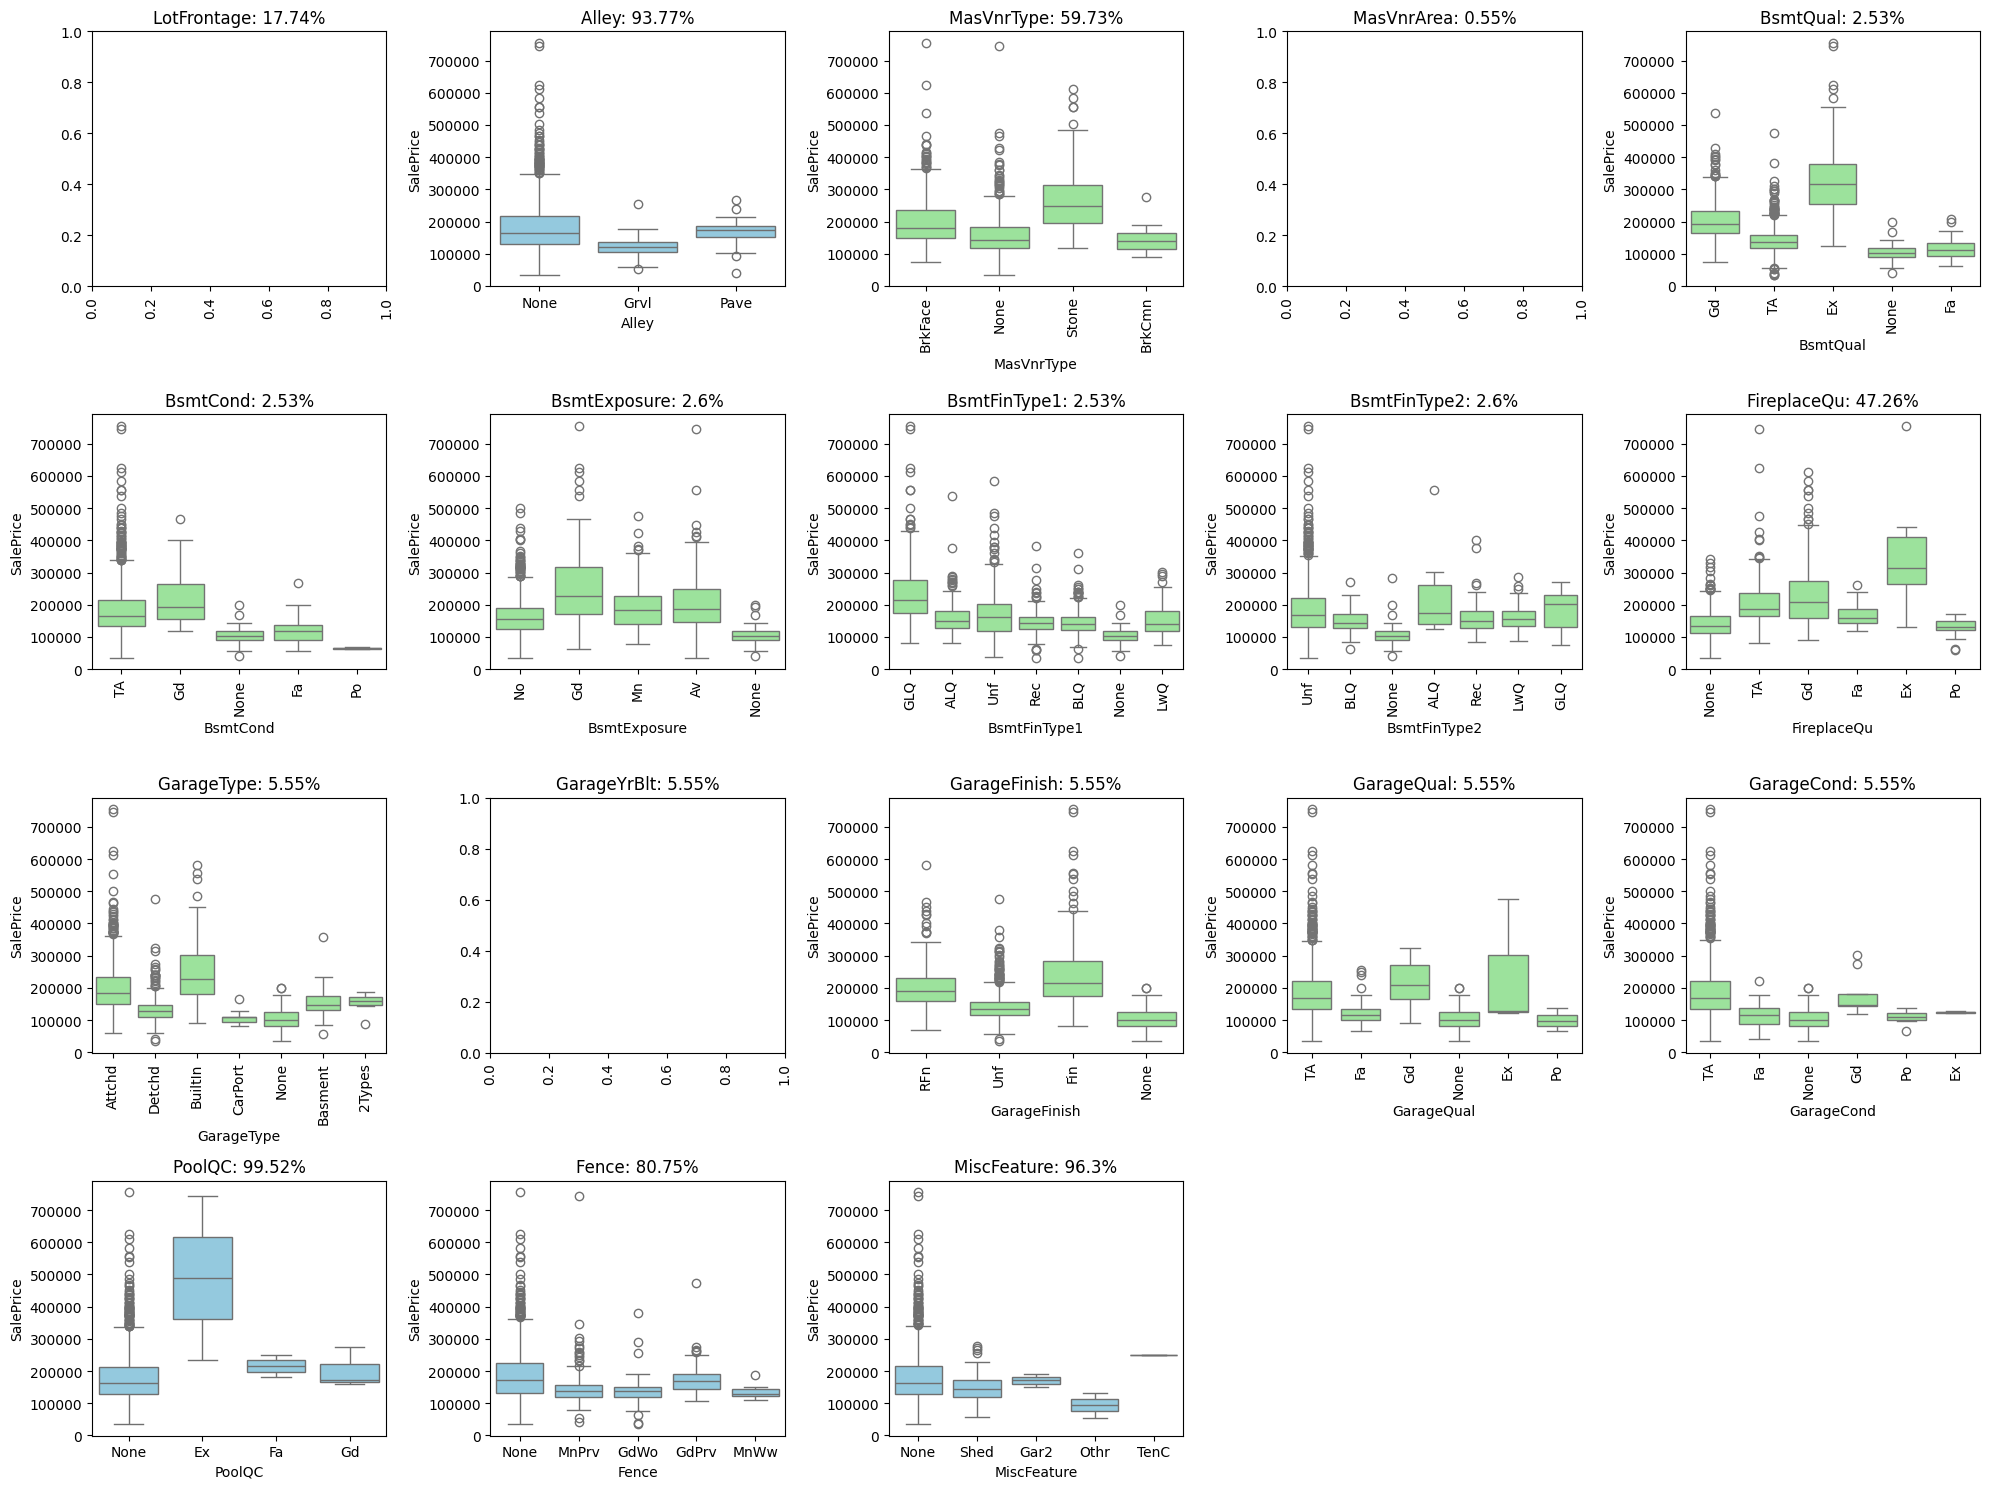

In [ ]:
train_df = train_ds.copy()

n_cols = 5
n_rows = (len(cols_na) + n_cols -1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

for i, (col, per) in enumerate(cols_na.items()):
  row_ind = i // n_cols
  col_ind = i % n_cols
  if per > 0.7:
    if train_df[col].dtype != 'object':
      train_df[col] = train_df[col].fillna(0)
      if train_df[col].nunique() < 10:
        # print(f'{col}: {train_df[col].unique()}')
        sns.boxplot(x=col, y='SalePrice', data=train_df, color='skyblue',ax=axs[row_ind, col_ind])
    else:
      train_df[col] = train_df[col].fillna('None')
      if train_df[col].nunique() < 10:
        # print(f'{col}: {train_df[col].unique()}')
        sns.boxplot(x=col, y='SalePrice', data=train_df, color='skyblue',ax=axs[row_ind, col_ind])
  else:
    if train_df[col].dtype != 'object':
      train_df[col] = train_df[col].fillna(0)
      if train_df[col].nunique() < 10:
        # print(f'{col}: {train_df[col].unique()}')
        sns.boxplot(x=col, y='SalePrice', data=train_df, color='lightgreen',ax=axs[row_ind, col_ind])
    else:
      train_df[col] = train_df[col].fillna('None')
      if train_df[col].nunique() < 10:
        # print(f'{col}: {train_df[col].unique()}')
        sns.boxplot(x=col, y='SalePrice', data=train_df, color='lightgreen',ax=axs[row_ind, col_ind])
    axs[row_ind, col_ind].tick_params(axis='x', rotation=90)
  axs[row_ind, col_ind].set_title(f'{col}: {round(per * 100, 3)}%')

for i in range(len(cols_na), n_rows * n_cols):
  row_ind = i // n_cols
  col_ind = i % n_cols
  fig.delaxes(axs[row_ind, col_ind])
plt.tight_layout()
plt.show()

In [ ]:
''' Lets fill the null values.'''
cols_none = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
             'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

cols_zero = ['GarageYrBlt', 'MasVnrArea']

train_ds[cols_none] = train_ds[cols_none].fillna('None')

train_ds[cols_zero] = train_ds[cols_zero].fillna(0)

train_ds['LotFrontage'] = train_ds['LotFrontage'].fillna(train_ds['LotFrontage'].median())

#lets do the same for test data
test_ds[cols_none] = test_ds[cols_none].fillna('None')

test_ds[cols_zero] = test_ds[cols_zero].fillna(0)

test_ds['LotFrontage'] = test_ds['LotFrontage'].fillna(test_ds['LotFrontage'].median())


In [ ]:
set(test_ds.dtypes.tolist())

{dtype('int64'), dtype('float64'), dtype('O')}

In [ ]:
test_cols_na = {col: (float(round(test_ds[col].isnull().mean(), 4)), test_ds[col].dtype) for col in test_ds.columns if test_ds[col].isnull().sum() > 1}
test_cols_na

{'MSZoning': (0.0027, dtype('O')),
 'Utilities': (0.0014, dtype('O')),
 'BsmtFullBath': (0.0014, dtype('float64')),
 'BsmtHalfBath': (0.0014, dtype('float64')),
 'Functional': (0.0014, dtype('O'))}

In [ ]:
for col in test_cols_na.keys():
  if test_ds[col].dtype != 'object':
    test_ds[col] = test_ds[col].fillna(test_ds[col].median())
  else:
    test_ds[col] = test_ds[col].fillna(test_ds[col].mode()[0])


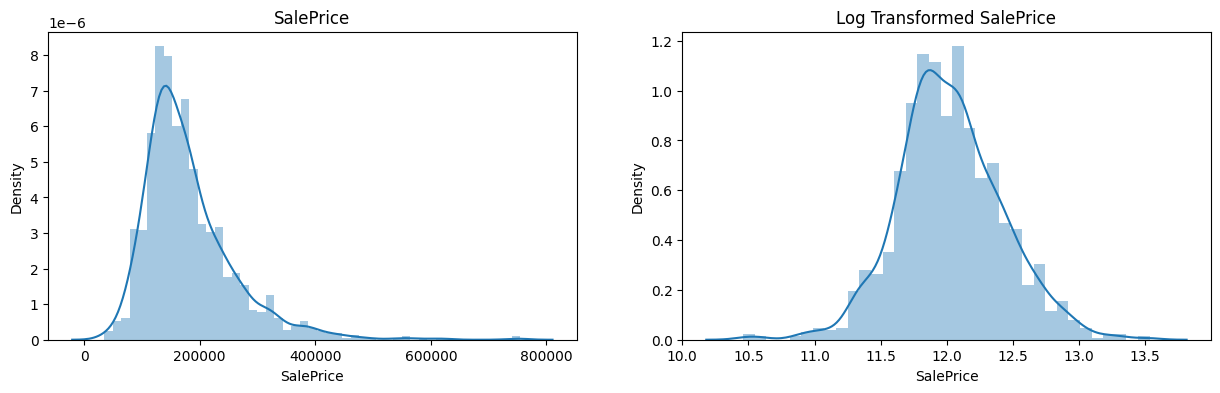

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(train_ds['SalePrice'], ax=axs[0])
axs[0].set_title('SalePrice')
sns.distplot(np.log1p(train_ds['SalePrice']), ax=axs[1])
axs[1].set_title('Log Transformed SalePrice')
plt.show()

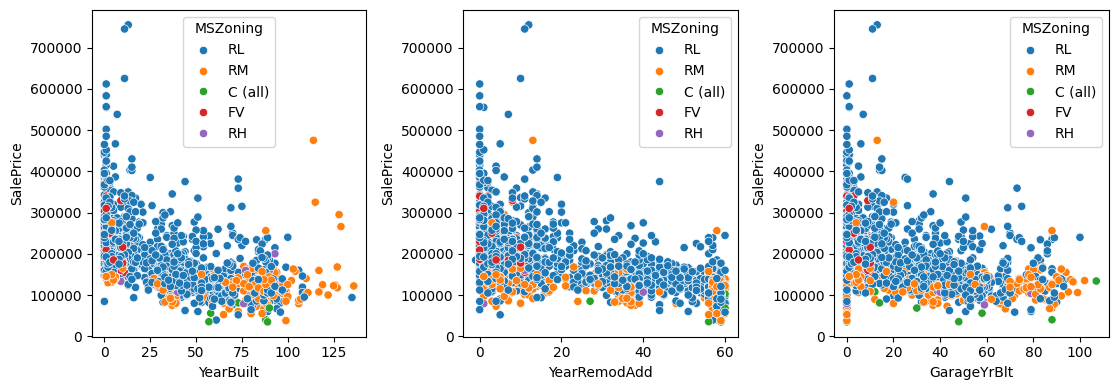

In [ ]:
year_cols = [col for col in train_ds.columns if 'yr' in col.lower() or 'year' in col.lower()]
n_cols = 4
fig, axs = plt.subplots(1, n_cols, figsize=(15, 4))
for i, col in enumerate(year_cols):
  if col != 'YrSold':
    df = train_ds.copy()
    if col == 'GarageYrBlt':
      df[col] = df[col].replace(0, np.nan)
      df[col] = df['YrSold'] - df[col]
      df[col] = df[col].fillna(0)
      sns.scatterplot(y=df['SalePrice'], x=df[col], data=df, hue='MSZoning', ax=axs[i])
    else:
      df[col] = df['YrSold'] - df[col]
      sns.scatterplot(y=df['SalePrice'], x=df[col], data=df, hue='MSZoning', ax=axs[i])

fig.delaxes(axs[3])
plt.tight_layout()
plt.show()

<Axes: xlabel='YrSold'>

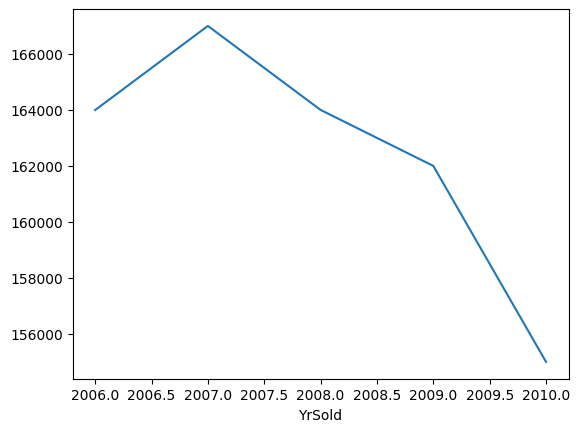

In [ ]:
# year sold vs price
train_ds.groupby('YrSold')['SalePrice'].median().plot(kind='line')

### Numerical Data Analysis

In [ ]:
num_cols = train_ds.select_dtypes(exclude='object').columns

disc_cols = {col: train_ds[col].nunique() for col in num_cols if train_ds[col].nunique() < 25 and col not in year_cols+['Id']}

In [ ]:
train_ds[num_cols].corr()['SalePrice'].abs().sort_values(ascending=False)[1:16].reset_index().plot(kind='barh', x='index', figsize=(10, 6), title='Top 15 correlations with SalePrice')
plt.show()

In [ ]:
n_cols = 5
n_rows = (len(disc_cols) + n_cols -1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 12))
for i, col in enumerate(disc_cols):
    train_df = train_ds.copy()

    row_ind = i // n_cols
    col_ind = i % n_cols
    train_df[col] = train_df.groupby(col)['SalePrice'].median().plot.bar(x='MSSubClass', y='SalePrice', ax=axs[row_ind, col_ind])
    # sns.barplot(data=train_df, x=train_df[col], ax=axs[row_ind, col_ind])
    axs[row_ind, col_ind].set_title(col)
    axs[row_ind, col_ind].set_ylabel('SalePrice')
    axs[row_ind, col_ind].tick_params(axis='x', rotation=90)

#hide un used ones
for i in range(len(disc_cols), n_rows * n_cols):
    row_ind = i // n_cols
    col_ind = i % n_cols
    fig.delaxes(axs[row_ind, col_ind])

plt.tight_layout()
plt.show()

In [ ]:
cols = 5
rows = (len(disc_cols) + cols -1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(18, 14))
for i, col in enumerate(disc_cols):
  row_ind = i // cols
  col_ind = i % cols
  sns.boxplot(x=train_ds[col], ax=axs[row_ind, col_ind])
  axs[row_ind, col_ind].set_title(col)

for i in range(len(disc_cols), rows * cols):
  row_ind = i // cols
  col_ind = i % cols
  fig.delaxes(axs[row_ind, col_ind])

plt.tight_layout()
plt.show()

In [ ]:
cont_cols = {col: train_ds[col].nunique() for col in train_ds if train_ds[col].nunique() > 25 and col not in [disc_cols.keys()]+year_cols+['Id']}

In [ ]:
#scatter plot for numerical columns and salePrice
n_cols = 5
n_rows = (len(num_cols) + n_cols -1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 30))
for i, col in enumerate(num_cols):
  if col != 'Id':
    row_ind = i // n_cols
    col_ind = i % n_cols
    sns.scatterplot(x=train_ds[col], y=train_ds['SalePrice'], ax=axs[row_ind, col_ind])
    axs[row_ind, col_ind].set_title(col)
    axs[row_ind, col_ind].set_ylabel('SalePrice')
    axs[row_ind, col_ind].tick_params(axis='x', rotation=90)
plt.tight_layout(); plt.show()

In [ ]:
print(train_ds.shape)
print(test_ds.shape)

(1415, 81)
(1459, 80)


In [ ]:
n_cols = 5
n_rows = (len(cont_cols) + n_cols -1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 14))
for i, col in enumerate(cont_cols):
    train_df = train_ds.copy()

    row_ind = i // n_cols
    col_ind = i % n_cols

    train_df[col].hist(bins=25, ax=axs[row_ind, col_ind])
    axs[row_ind, col_ind].set_xlabel(col)
    axs[row_ind, col_ind].set_ylabel('Count')
    axs[row_ind, col_ind].set_title(f'{col}: Distribution')
    # axs[row_ind, col_ind].tick_params(axis='x', rotation=90)

#hide un used ones
for i in range(len(cont_cols), n_rows * n_cols):
    row_ind = i // n_cols
    col_ind = i % n_cols
    fig.delaxes(axs[row_ind, col_ind])

plt.tight_layout()
plt.show()

In [ ]:
n_cols = 5
n_rows = (len(cont_cols) + n_cols -1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 14))
for i, col in enumerate(cont_cols):
  row_ind = i // n_cols
  col_ind = i % n_cols
  sns.boxplot(x=train_ds[col], ax=axs[row_ind, col_ind])
  axs[row_ind, col_ind].set_title(col)

for i in range(len(cont_cols), n_rows * n_cols):
  row_ind = i // n_cols
  col_ind = i % n_cols
  fig.delaxes(axs[row_ind, col_ind])

plt.tight_layout()
plt.show()

In [ ]:
cols = 5
rows = (len(disc_cols) + cols -1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(18, 14))
for i, col in enumerate(disc_cols):
  row_ind = i // cols
  col_ind = i % cols
  sns.boxplot(x=train_ds[col], ax=axs[row_ind, col_ind])
  axs[row_ind, col_ind].set_title(col)

for i in range(len(disc_cols), rows * cols):
  row_ind = i // cols
  col_ind = i % cols
  fig.delaxes(axs[row_ind, col_ind])

plt.tight_layout()
plt.show()

n_cols = 5
n_rows = (len(cont_cols) + n_cols -1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 14))
for i, col in enumerate(cont_cols):
  row_ind = i // n_cols
  col_ind = i % n_cols
  sns.boxplot(x=train_ds[col], ax=axs[row_ind, col_ind])
  axs[row_ind, col_ind].set_title(col)

for i in range(len(cont_cols), n_rows * n_cols):
  row_ind = i // n_cols
  col_ind = i % n_cols
  fig.delaxes(axs[row_ind, col_ind])

plt.tight_layout()
plt.show()

### Outlier Treatment.

In [ ]:
#I'll see scatter plot of numerical columns and their SalePrice and i'll store the enteries that i see as outliers.
outliers = []

outliers.append(train_ds[(train_ds['MSSubClass'] == 60) & (train_ds['SalePrice'] >= 600000)]['Id'].values)
outliers.append(train_ds[(train_ds['LotFrontage'] > 200) & (train_ds['SalePrice'] < 400000)]['Id'].values)

outliers.append(train_ds[(train_ds['OverallQual'] == 4) & (train_ds['SalePrice'] > 200000)]['Id'].values)
outliers.append(train_ds[(train_ds['OverallQual'] == 8) & (train_ds['SalePrice'] > 500000)]['Id'].values)

outliers.append(train_ds[(train_ds['OverallCond'] == 2) & (train_ds['SalePrice'] > 300000)]['Id'].values)
outliers.append(train_ds[(train_ds['OverallCond'] == 5) & (train_ds['SalePrice'] > 600000)]['Id'].values)
outliers.append(train_ds[(train_ds['OverallCond'] == 6) & (train_ds['SalePrice'] > 600000)]['Id'].values)

outliers.append(train_ds[(train_ds['YearBuilt'] < 1900) & (train_ds['SalePrice'] > 270000)]['Id'].values)
outliers.append(train_ds[(train_ds['YearBuilt'] < 2000) & (train_ds['SalePrice'] > 690000)]['Id'].values)

outliers.append(train_ds[(train_ds['YearRemodAdd'] < 1980) & (train_ds['SalePrice'] > 310000)]['Id'].values)
outliers.append(train_ds[(train_ds['YearRemodAdd'] < 2000) & (train_ds['SalePrice'] > 700000)]['Id'].values)

outliers.append(train_ds[(train_ds['MasVnrArea'] == 0) & (train_ds['SalePrice'] > 700000)]['Id'].values)
outliers.append(train_ds[(train_ds['MasVnrArea'] > 1200) & (train_ds['SalePrice'] < 300000)]['Id'].values)

outliers.append(train_ds[(train_ds['BsmtFinSF1'] > 4000) & (train_ds['SalePrice'] < 300000)]['Id'].values)
outliers.append(train_ds[(train_ds['BsmtFinSF2'] > 1200) & (train_ds['SalePrice'] < 400000)]['Id'].values)

outliers.append(train_ds[(train_ds['TotalBsmtSF'] > 4000) & (train_ds['SalePrice'] < 300000)]['Id'].values)
outliers.append(train_ds[(train_ds['1stFlrSF'] > 3000) & (train_ds['SalePrice'] < 300000)]['Id'].values)
outliers.append(train_ds[(train_ds['GrLivArea'] > 4000) & (train_ds['SalePrice'] < 300000)]['Id'].values)

outliers.append(train_ds[(train_ds['BsmtFullBath'] == 0) & (train_ds['SalePrice'] > 700000)]['Id'].values)
outliers.append(train_ds[(train_ds['BsmtFullBath'] == 1) & (train_ds['SalePrice'] > 700000)]['Id'].values)
outliers.append(train_ds[(train_ds['BsmtFullBath'] == 3) & (train_ds['SalePrice'] < 300000)]['Id'].values)

outliers.append(train_ds[(train_ds['BsmtHalfBath'] == 0) & (train_ds['SalePrice'] > 700000)]['Id'].values)
outliers.append(train_ds[(train_ds['BsmtHalfBath'] == 1) & (train_ds['SalePrice'] > 700000)]['Id'].values)
outliers.append(train_ds[(train_ds['BsmtHalfBath'] == 2) & (train_ds['SalePrice'] < 200000)]['Id'].values)

outliers.append(train_ds[(train_ds['FullBath'] == 0) & (train_ds['SalePrice'] > 350000)]['Id'].values)
outliers.append(train_ds[(train_ds['HalfBath'] == 1) & (train_ds['SalePrice'] > 600000)]['Id'].values)

outliers.append(train_ds[(train_ds['BedroomAbvGr'] > 6) & (train_ds['SalePrice'] < 400000)]['Id'].values)
outliers.append(train_ds[(train_ds['BedroomAbvGr'] == 4) & (train_ds['SalePrice'] > 600000)]['Id'].values)
outliers.append(train_ds[(train_ds['BedroomAbvGr'] == 2) & (train_ds['SalePrice'] > 500000)]['Id'].values)
outliers.append(train_ds[(train_ds['BedroomAbvGr'] == 1) & (train_ds['SalePrice'] > 450000)]['Id'].values)

outliers.append(train_ds[(train_ds['KitchenAbvGr'] == 1) & (train_ds['SalePrice'] > 620000)]['Id'].values)
outliers.append(train_ds[(train_ds['KitchenAbvGr'] > 2) & (train_ds['SalePrice'] < 320000)]['Id'].values)

outliers.append(train_ds[(train_ds['TotRmsAbvGrd'] > 12.5) & (train_ds['SalePrice'] < 320000)]['Id'].values)
outliers.append(train_ds[(train_ds['TotRmsAbvGrd'] == 10) & (train_ds['SalePrice'] > 600000)]['Id'].values)

outliers.append(train_ds[(train_ds['Fireplaces'] == 2) & (train_ds['SalePrice'] > 600000)]['Id'].values)
outliers.append(train_ds[(train_ds['Fireplaces'] > 2) & (train_ds['SalePrice'] < 300000)]['Id'].values)

outliers.append(train_ds[(train_ds['GarageCars'] == 3) & (train_ds['SalePrice'] > 620000)]['Id'].values)
outliers.append(train_ds[(train_ds['GarageCars'] > 3) & (train_ds['SalePrice'] < 320000)]['Id'].values)

outliers.append(train_ds[(train_ds['GarageArea'] < 1000) & (train_ds['SalePrice'] > 620000)]['Id'].values)
outliers.append(train_ds[(train_ds['GarageArea'] > 1000) & (train_ds['SalePrice'] < 350000)]['Id'].values)

outliers.append(train_ds[(train_ds['WoodDeckSF'] > 700) & (train_ds['SalePrice'] < 400000)]['Id'].values)
outliers.append(train_ds[(train_ds['WoodDeckSF'] < 400) & (train_ds['SalePrice'] > 700000)]['Id'].values)

outliers.append(train_ds[(train_ds['OpenPorchSF'] < 200) & (train_ds['SalePrice'] > 700000)]['Id'].values)
outliers.append(train_ds[(train_ds['OpenPorchSF'] > 400) & (train_ds['SalePrice'] < 300000)]['Id'].values)

outliers.append(train_ds[(train_ds['EnclosedPorch'] > 370) & (train_ds['SalePrice'] < 400000)]['Id'].values)
outliers.append(train_ds[(train_ds['EnclosedPorch'] == 0) & (train_ds['SalePrice'] > 700000)]['Id'].values)


outliers.append(train_ds[(train_ds['3SsnPorch'] == 0) & (train_ds['SalePrice'] > 700000)]['Id'].values)
outliers.append(train_ds[(train_ds['ScreenPorch'] == 0) & (train_ds['SalePrice'] > 700000)]['Id'].values)
outliers.append(train_ds[(train_ds['PoolArea'] == 0) & (train_ds['SalePrice'] > 700000)]['Id'].values)
outliers.append(train_ds[(train_ds['MiscVal'] == 0) & (train_ds['SalePrice'] > 700000)]['Id'].values)
outliers.append(train_ds[(train_ds['YrSold'] <= 2007) & (train_ds['SalePrice'] > 550000)]['Id'].values)

real_outliers = {}
for outlier in outliers:
  for out in outlier:
    if out not in real_outliers.keys():
      real_outliers[int(out)] = 1
    else:
      real_outliers[int(out)] += 1
print(sorted(real_outliers.items(), key=lambda x: x[1], reverse=True))

[]


In [ ]:
#lets drop these outliers
train_ds = train_ds[~train_ds['Id'].isin(real_outliers.keys())]

In [ ]:
#Define the functions that i'd treat the outliers with
def iqr(df, col):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return lower_bound, upper_bound

def find_outliers(df, col):
  lower_bound, upper_bound = iqr(df, col)

  outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
  return outliers

def cap(df, col):
  lower_bound, upper_bound = iqr(df, col)

  df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
  df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
  return df[col]

def trim(df, col):
  lower_bound, upper_bound = iqr(df, col)

  df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
  return df

In [ ]:
def outlier_treatment(df: pd.DataFrame, is_test_set: bool = False):
  df_treated = df.copy()
  log_transformed = {}
  outlier_tr_strategy = {}
  num_cols = df_treated.select_dtypes(exclude='object').columns

  for col in num_cols:
    outliers = find_outliers(df_treated, col)
    if len(outliers) == 0:
      pass
    elif abs(df_treated[col].skew()) > 1:
      outlier_tr_strategy[col] = 'Log transformation'
      df_treated[col] = np.log1p(df_treated[col])
      log_transformed[col] = "np.log1"
    elif len(outliers) < len(df_treated) * 0.01 and not is_test_set: # Only trim training set
      outlier_tr_strategy[col] = 'Removal or capping'
      # df_treated = trim(df_treated, col)
      df_treated[col] = cap(df_treated, col)
    else: # Apply capping for test set or for training set columns with >= 1% outliers
      outlier_tr_strategy[col] = 'Capping'
      df_treated[col] = cap(df_treated, col)
  return df_treated, log_transformed

In [ ]:
print(train_ds.shape)
print(test_ds.shape)

(1460, 81)
(1459, 80)


In [ ]:
print(len(log_transformed.keys()))

31


### Categorical Data Analysis.

In [ ]:
categorical_cols = train_ds.select_dtypes(include='object').columns

In [ ]:
train_ds.groupby(['Alley'])['SalePrice'].count()/len(train_ds)

In [ ]:
n_cols = 5

n_rows = (len(categorical_cols) + n_cols -1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 28))
for i, col in enumerate(categorical_cols):
    train_df = train_ds.copy()

    row_ind = i // n_cols
    col_ind = i % n_cols

    sns.boxplot(x=train_df[col], y='SalePrice',data=train_df, ax=axs[row_ind, col_ind])
    axs[row_ind, col_ind].set_title(col)
    axs[row_ind, col_ind].set_ylabel('SalePrice')
    axs[row_ind, col_ind].tick_params(axis='x', rotation=90)

#hide un used ones
for i in range(len(categorical_cols), n_rows * n_cols):
    row_ind = i // n_cols
    col_ind = i % n_cols
    fig.delaxes(axs[row_ind, col_ind])

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4))
train_ds
custom_colors = ['grey', 'lightcoral', '#99ff99', '#ffcc99', 'cyan']

dwelling_types = train_ds['BldgType'].value_counts()
n_houses = train_ds.shape[0]
axs[0].pie(dwelling_types, labels=dwelling_types.index, autopct='%1.1f%%', explode=[0.03]* len(dwelling_types))
axs[0].set_title('Dwelling Types')

train_ds['YrSold'].value_counts().plot.bar(ax=axs[1])
axs[1].set_title('Years Sold')

zones = train_ds['MSZoning'].value_counts()
explode = [0, 0.03, 0, 0, 0.3]
axs[2].pie(zones, labels=zones.index, autopct='%1.1f%%', explode=explode, startangle=180, colors=custom_colors)
axs[2].set_title('MSZoning')

zone_houses = train_ds.groupby(['MSZoning', 'BldgType']).size().reset_index()
zone_houses.columns = ['MSZoning', 'BldgType', 'Count']

sns.barplot(data=zone_houses, x = 'MSZoning', y='Count', hue='BldgType', ax=axs[3])
axs[3].set_title('houses Types per zone')

plt.tight_layout()
plt.show()
# train_ds['Neighborhood'].value_counts().plot.bar(ax=axs[2])

### Ordinal Encode.

Ordinal Encoding Some categorical columns.

In [ ]:
def ordinal_encode(df):
  df = df.copy()
  categorical_cols = df.select_dtypes(include=object).columns.tolist()

  not_target = ['Condition1', 'Condition2', 'SaleCondition']
  ordinal_cols = [col for col in categorical_cols if "Qual" in col or "Cond" in col or "QC" in col or "Qu" in col if col not in not_target]

  for col in ordinal_cols:
    df[col] = df[col].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}).astype(int)
  return df
train_ds = ordinal_encode(train_ds)
test_ds = ordinal_encode(test_ds)


In [ ]:
train_ds['Alley'].value_counts()

In [ ]:
train_ds['BsmtQual'].value_counts()

### Feature Engineering

In [ ]:
# Feature engineering.
def add_feature_final(df):
  df = df.copy()
  size = df.shape[1]
  cols = ["YrSold","YearBuilt","YearRemodAdd","1stFlrSF","2ndFlrSF","TotalBsmtSF",
          "FullBath","HalfBath","BsmtFullBath","BsmtHalfBath",
          "OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch",
          "GarageArea","GarageCars","GrLivArea","LotArea","Fireplaces","PoolArea",
          "WoodDeckSF","TotRmsAbvGrd","BedroomAbvGr","MasVnrArea","GarageYrBlt",
          "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","LotFrontage","OverallCond", "Fence", "LotConfig", "GarageYrBlt"]
  for col in cols:
    if col not in df.columns:
      df[col] = 0

    df['HasPool'] = (df['PoolArea'].fillna(0) > 0).astype(int)
    df['Has2ndFloor'] = (df['2ndFlrSF'].fillna(0) > 0).astype(int)
    df['HasBsmt'] = (df['TotalBsmtSF'].fillna(0) > 0).astype(int)
    df['HasWoodDeck'] = (df['WoodDeckSF'].fillna(0) > 0).astype(int)
    df['HasGarage'] = (df['GarageArea'].fillna(0) > 0).astype(int)
    df['HasFireplace'] = (df['Fireplaces'].fillna(0) > 0).astype(int)
    df['HasFence'] = (df['Fence'].fillna('None') != 'None').astype(int)
    df['HasPorch'] = (df['OpenPorchSF'].fillna(0) > 0).astype(int)

    df['IsNew'] = (df['YearBuilt'] >= (df['YrSold']-1)).astype(int)
    df['IsRemoded'] = (df['YearRemodAdd'] != (df['YearBuilt'])).astype(int)
    df['IsCornerLot'] = (df['LotConfig'] == "Corner").astype(int)

    df['Age'] = (df['YrSold'] - df['YearBuilt']).clip(lower=0)
    df['RemodedAge'] = (df['YrSold'] - df['YearRemodAdd']).clip(lower=0)

    df['GarageAge'] = (df['YrSold'] - df['GarageYrBlt'].replace(0, np.nan)).fillna(0).clip(lower=0)


    total_sf = (df[['1stFlrSF', 'TotalBsmtSF']].sum(axis=1) + df['2ndFlrSF']).round(2)
    df['TotalSF'] = total_sf.clip(upper=np.finfo(np.float64).max/4)

    total_sf_abv_grd = (df[['1stFlrSF']].sum(axis=1) + df['2ndFlrSF'])
    df['TotalSFAbvGrd'] = total_sf_abv_grd.clip(upper=np.finfo(np.float64).max/4)

    total_porch_sf = df[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].sum(axis=1)
    df['TotalPorchSF'] = total_porch_sf.clip(upper=np.finfo(np.float64).max/4)

    total_outdoors = df['TotalPorchSF'] + df[['WoodDeckSF', 'PoolArea']].sum(axis=1)
    df['TotalOutdoors'] = total_outdoors.clip(upper=np.finfo(np.float64).max/4)


    total_bath = df[['FullBath', 'BsmtFullBath']].sum(axis=1) + 0.5 *  df['HalfBath'] + 0.5 * df['BsmtHalfBath']
    df['TotalBath'] = total_bath.clip(upper=np.finfo(np.float64).max/4)

    total_bsmt_bath = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    df['TotalBsmtBath'] = total_bsmt_bath.clip(upper=np.finfo(np.float64).max/4)

    total_rooms = df['TotalBath'] + df['TotRmsAbvGrd']
    df['TotalRooms'] = total_rooms.clip(upper=np.finfo(np.float64).max/4)

    bath_per_bedroom = (df['TotalBath'] / df['BedroomAbvGr'].replace(0, np.nan)).fillna(0)
    df['BathPerBedroom'] = bath_per_bedroom.clip(upper=np.finfo(np.float64).max/4)

    living_per_room_raw = (df['GrLivArea'] / df['TotRmsAbvGrd'].replace(0, np.nan)).fillna(0)
    df['LivingPerRoom'] = living_per_room_raw.fillna(living_per_room_raw.median()).clip(upper=np.finfo(np.float64).max/4)

    df['OverallScore'] = (df['OverallQual'] * df['OverallCond']).clip(lower=0)
    df['OverallScore'] = df['OverallScore'].clip(upper=np.finfo(np.float64).max/4)

    avg_rm_sf_abf_grd_raw = ((df[['1stFlrSF']].sum(axis=1) + df['2ndFlrSF']) / df['TotRmsAbvGrd'].replace(0, np.nan))
    df['AvgRmSFAbfGrd'] = avg_rm_sf_abf_grd_raw.fillna(avg_rm_sf_abf_grd_raw.median()).clip(upper=np.finfo(np.float64).max/4)


    numerical_features_created = [col for col in df.columns if col not in cols and df[col].dtype != 'object']
    for col in numerical_features_created:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].median())


    size = df.shape[1] - size
    return df, size

train_ds, size = add_feature_final(train_ds)
test_ds, size = add_feature_final(test_ds)

In [ ]:
print(train_ds.shape)
print(test_ds.shape)

(1460, 106)
(1459, 105)


In [ ]:
#drop Id from both train and test data.
train_ds = train_ds.drop('Id', axis=1)

Test_Id = test_ds['Id']
test_ds = test_ds.drop('Id', axis=1)

print(train_ds.shape)
print(test_ds.shape)

(1450, 105)
(1459, 104)


In [ ]:
train_ds, log_transformed = outlier_treatment(train_ds)
test_ds, log_transformed = outlier_treatment(test_ds, is_test_set=True)

### Data Preparation and Modelin.

In [ ]:
X = train_ds.drop(['SalePrice'], axis=1)
y = train_ds['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
numerical_cols = X_train.select_dtypes(exclude=object).columns.tolist()
categorical_cols = X_train.select_dtypes(include=object).columns.tolist()

num_pipe = Pipeline(steps=[
    ('scale', StandardScaler())
    ])
cat_pipe = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, numerical_cols),
        ('cat', cat_pipe, categorical_cols)
    ])

In [ ]:
null_test_cols = {col: test_ds[col].isnull().mean() for col in test_ds.columns if test_ds[col].isnull().mean() != 0}
for col in null_test_cols:
  if test_ds[col].dtype != 'object':
    test_ds[col] = test_ds[col].fillna(test_ds[col].median())
  else:
    test_ds[col] = test_ds[col].fillna(test_ds[col].mode()[0])

In [ ]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_val)

In [ ]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(),
    'ElasticNet': ElasticNet(),
}

In [ ]:
results = {}
for name, model in models.items():
  model.fit(X_train_processed, y_train)
  y_pred = model.predict(X_test_processed)
  rmse = np.sqrt(mean_squared_error(y_val, y_pred))
  results[name] = rmse

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE'])
results_df = results_df.sort_values(by='RMSE')
print("Model Evaluation Results:")
display(results_df)

Model Evaluation Results:


,RMSE
Ridge,0.120251
LinearRegression,0.124966
RandomForestRegressor,0.131404
XGBRegressor,0.141439
ElasticNet,0.373381


### Fine Tunning.

In [ ]:
import optuna

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-3, 10.0, log=True)

    model = Ridge(alpha=alpha)
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ", study.best_trial.params)

[I 2025-09-16 12:06:05,809] A new study created in memory with name: no-name-f38b9b0a-8c07-4c68-83ce-89c1205b0d8b
[I 2025-09-16 12:06:05,833] Trial 0 finished with value: 0.12360636688174934 and parameters: {'alpha': 0.06813594724783613}. Best is trial 0 with value: 0.12360636688174934.
[I 2025-09-16 12:06:05,856] Trial 1 finished with value: 0.12020840170904454 and parameters: {'alpha': 5.266282160552275}. Best is trial 1 with value: 0.12020840170904454.
[I 2025-09-16 12:06:05,898] Trial 2 finished with value: 0.12459219146098888 and parameters: {'alpha': 0.0016751888872210882}. Best is trial 1 with value: 0.12020840170904454.
[I 2025-09-16 12:06:05,946] Trial 3 finished with value: 0.12442746706520884 and parameters: {'alpha': 0.01409066721777309}. Best is trial 1 with value: 0.12020840170904454.
[I 2025-09-16 12:06:05,974] Trial 4 finished with value: 0.123920152845544 and parameters: {'alpha': 0.045021939932016884}. Best is trial 1 with value: 0.12020840170904454.
[I 2025-09-16 12:

Best trial:
  Value:  0.11988596476698218
  Params:  {'alpha': 2.178044321553193}


In [ ]:
model = Ridge(alpha=study.best_trial.params['alpha'])
model.fit(X_train_processed, y_train)
y_pred = model.predict(X_test_processed)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

0.11988596476698218


### Testing model on Test data and submitting.

In [ ]:
X_test_final_processed = preprocessor.transform(test_ds)

y_test_pred = model.predict(X_test_final_processed)
y_test_pred = np.expm1(y_test_pred)

submission_df = pd.DataFrame({'Id': Test_Id, 'SalePrice': y_test_pred})
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully!")
submission_df.head().round(3)

Submission file created successfully!


,Id,SalePrice
0,1461,652516.363
1,1462,1080920.257
2,1463,862110.047
3,1464,1005521.933
4,1465,770808.274
